In [7]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import tqdm 
from matplotlib import pyplot as plt


In [114]:
class Scale(nn.Module):
    def __init__(self, scale=1.0, train=False, use_sigmoid=False):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(scale), requires_grad=train)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        if self.use_sigmoid:
            return x * torch.sigmoid(self.scale)
        return x * self.scale

def topk_mask(x, k):
    shape = x.shape
    x = x.view(-1)
    smallest = torch.topk(x, k)[0][-1]
    x = x * (x >= smallest).float()
    return x.view(shape)

class StraightThroughEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, mask):
      return mask
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None


class GEMLinear(nn.Linear):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        topk=None,
        threshold=0.5,
        device=None,
        dtype=None,
        train_weights=False,
    ) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        self.weight.requires_grad_(train_weights)
        self.scores = nn.Parameter(torch.rand_like(self.weight), requires_grad=True)
        self.topk = topk
        self.threshold = threshold
        
    def train_weights(self, train=True):
        self.weight.requires_grad_ = train

    def get_mask(self):
        if self.topk is None:
            mask = (self.scores > self.threshold).float()
        else: 
            mask = topk_mask(self.scores, self.topk)
        return StraightThroughEstimator.apply(self.scores, mask)

    def sparsity(self):
        with torch.no_grad():
            return 1 - self.get_mask().sum() / self.get_mask().numel()


    def masked_weight(self):
        return self.weight * self.get_mask()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return nn.functional.linear(input, self.masked_weight(), self.bias)

def load_data(dataset, batch_size, shuffle=True, seed=None):
    if batch_size == -1:
        batch_size = len(dataset)
    data = dataset.data
    targets = dataset.targets
    if seed is not None:
        torch.manual_seed(seed)
    if shuffle:
        idxs = torch.randperm(len(dataset))
    else:
        idxs = torch.arange(len(dataset))

    for i in range(len(dataset) // batch_size):
        lhs = i * batch_size
        rhs = (i + 1) * batch_size
        idx = idxs[lhs:rhs]
        yield (data[idx], targets[idx])


class Loader:
    def __init__(self, dataset, batch_size=-1, shuffle=True, device=None) -> None:
        if batch_size == -1:
            batch_size = len(dataset)
        self.loader = load_data(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
        if device is not None:
            self.loader = [(d.to(device), t.to(device)) for d,t  in self.loader]
        self.length = len(dataset) // batch_size

    def __len__(self):
        return self.length

    def __iter__(self):
        return iter(self.loader)


def accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true).float().mean() * 100


In [104]:
DEV = torch.device('cuda:0')

train_dataset = MNIST(root='/data/ml_data', train=True, download=True)
val_dataset = MNIST(root='/data/ml_data', train=False, download=True)
train_dataset.data = train_dataset.data.float() / 255
val_dataset.data = val_dataset.data.float() / 255

trainloader = Loader(train_dataset, batch_size=-1, device=DEV)
valloader = Loader(val_dataset, batch_size=-1, device=DEV)

In [122]:
EPOCHS = 10000
hidden_dim = 100
alpha = 0
scale = 0.9

# model = nn.Sequential(
#   nn.Flatten(),
#   GEMLinear(28*28, hidden_dim, topk=int(hidden_dim*28*28)//10),
#   nn.ReLU(),
#   GEMLinear(hidden_dim, hidden_dim, topk=int(hidden_dim*hidden_dim)//10),
#   nn.ReLU(),
#   GEMLinear(hidden_dim, 10, topk=int(hidden_dim*10)//10),
# ).to(DEV)

model = nn.Sequential(
  nn.Flatten(),
  Scale(scale, train=False),
  GEMLinear(28*28, 10, threshold=0.5),
  # nn.ReLU(),
  # GEMLinear(hidden_dim, hidden_dim, threshold=0.5),
  # nn.ReLU(),
  # GEMLinear(hidden_dim, 10, threshold=0.5),
).to(DEV)

pbar = tqdm.trange(EPOCHS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in pbar:
  for x, y in trainloader:
    optimizer.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y) + alpha * sum([module.scores.pow(2).sum() for module in model if hasattr(module, 'scores')])
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    acc = accuracy(y_hat, y)
    pbar.set_description(f'L: {loss.item():.3f}, A: {acc.item():.1f}')

  for x, y in valloader:
    with torch.no_grad():
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      acc = accuracy(y_hat, y)
      sparsities = [f"{module.sparsity()*100:.1f}" for module in model if hasattr(module, 'sparsity')]
      pbar.set_postfix_str(f'Val L: {loss.item():.3f}, A: {acc.item():.1f} |\t Sparsities: {sparsities}')


L: 1.922, A: 68.1: 100%|██████████| 10000/10000 [00:45<00:00, 219.54it/s, Val L: 1.917, A: 70.1 |	 Sparsities: ['51.1']]


In [120]:
def plot_weights(model):
    last_layer = model[-1]
    filters = last_layer.masked_weight().view(10, 28, 28)
    fig, axes = plt.subplots(1, len(filters), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(filters[i].detach().cpu().numpy(), )
        ax.set_title(f'{i}')
    plt.show()

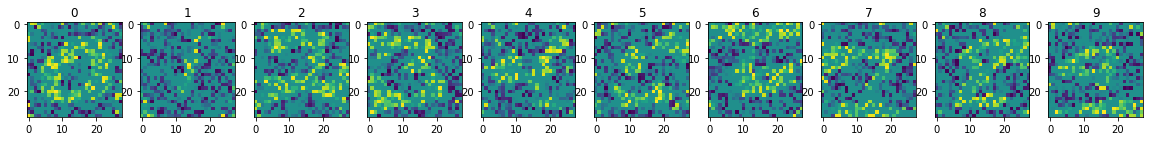

In [123]:
plot_weights(model)